# Rigid or Affine Registration without LDDMM

In [1]:
import sys
sys.path.insert(0,'../') # add code directory to path
# import lddmm
import torch_lddmm
# import numpy
import numpy as np
# import nibabel for i/o
import nibabel as nib
# import matplotlib for display
import matplotlib.pyplot as plt

## Load images as numpy arrays - Human Brain MRI

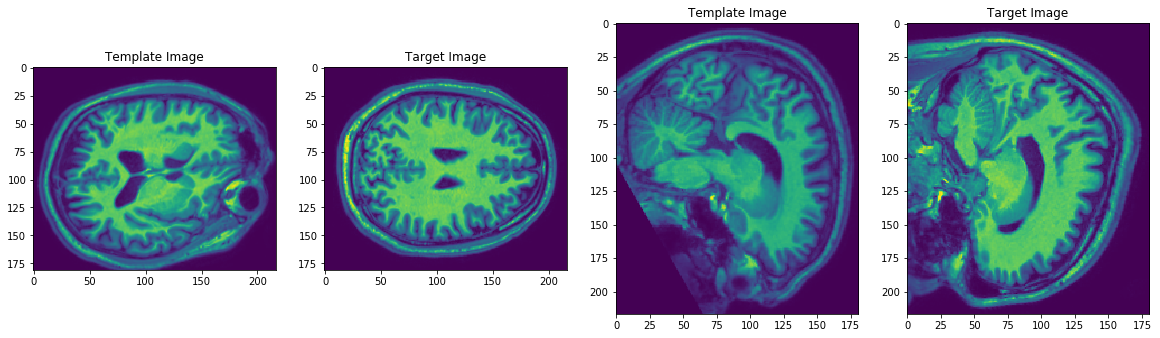

In [2]:
# set image file names
template_file_name = '../notebook/human_brain_affine.img'
target_file_name = '../notebook/Adt27-55_03_Adt27-55_03_MNI.img'

# load images
template_image_struct = nib.load(template_file_name)
target_image_struct = nib.load(target_file_name)

# set image spacing from template image, assume both images are the same spacing
dx = template_image_struct.header['pixdim'][1:4]

# get images as 3D numpy arrays
template_image = np.squeeze(template_image_struct.get_data()).astype(np.float32)
target_image = np.squeeze(target_image_struct.get_data()).astype(np.float32)

# draw a slice of each brain
plt.rcParams["figure.figsize"]=20,20
plt.figure()
plt.subplot(1,4,1)
plt.imshow(template_image[:,:,100])
plt.title('Template Image')
plt.subplot(1,4,2)
plt.imshow(target_image[:,:,100])
plt.title('Target Image')
plt.subplot(1,4,3)
plt.imshow(template_image[105,:,:])
plt.title('Template Image')
plt.subplot(1,4,4)
plt.imshow(target_image[105,:,:])
plt.title('Target Image')
plt.show()

## Run rigid-only alignment

In [9]:
# create torch_lddmm object
# here, we manually set:
# do_affine = 1 (this indicates rigid, 2 indicates affine)
# do_lddmm = 0
lddmm = torch_lddmm.LDDMM(template=template_image,target=target_image,outdir='../notebook/',do_affine=2,do_lddmm=0,niter=1000,epsilonL=2e-10,epsilonT=2e-9,sigma=20.0,optimizer='gdr',dx=dx)


Current parameters:
>    a               = 5.0 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 1000 (number of iterations)
>    epsilon         = 0.005 (gradient descent step size)
>    epsilonL        = 2e-10 (gradient descent step size, affine)
>    epsilonT        = 2e-09 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = 20.0 (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 1.0 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 5 (number of time steps in velocity field)
>    do_lddmm        = 0 (perform LDDMM step, 0 = no, 1 = yes)
>    do_affine       = 2 (interleave linear registration: 0 = no, 1 = affine, 2 = rigid)
>    checkaffinestep = 0 (evaluate linear matching energy: 0 = no, 1 = yes)
>    im_norm_ms      = 0 (normalize image by mean and std: 0 = no, 1 = yes)
>    gpu_number      = 0 (index of CU

In [10]:
# run computation
lddmm.run()
print(lddmm.affineA)

iter: 0, E = 30311928.0000, ER = 0.0000, EM = 30311928.0000, epd = 0.005000.
iter: 1, E= 30212802.000, ER= 0.000, EM= 30212802.000, epd= 0.005, time= 0.12s.
iter: 2, E= 30122598.000, ER= 0.000, EM= 30122598.000, epd= 0.005, time= 0.12s.
iter: 3, E= 30041404.000, ER= 0.000, EM= 30041404.000, epd= 0.005, time= 0.12s.
iter: 4, E= 29969324.000, ER= 0.000, EM= 29969324.000, epd= 0.005, time= 0.12s.
iter: 5, E= 29906460.000, ER= 0.000, EM= 29906460.000, epd= 0.005, time= 0.12s.
iter: 6, E= 29852940.000, ER= 0.000, EM= 29852940.000, epd= 0.005, time= 0.12s.
iter: 7, E= 29808890.000, ER= 0.000, EM= 29808890.000, epd= 0.005, time= 0.12s.
iter: 8, E= 29774316.000, ER= 0.000, EM= 29774316.000, epd= 0.005, time= 0.12s.
iter: 9, E= 29747572.000, ER= 0.000, EM= 29747572.000, epd= 0.005, time= 0.12s.
iter: 10, E= 29726076.000, ER= 0.000, EM= 29726076.000, epd= 0.003, time= 0.12s.
iter: 11, E= 29707658.000, ER= 0.000, EM= 29707658.000, epd= 0.002, time= 0.12s.
iter: 12, E= 29689704.000, ER= 0.000, EM=

## Display result

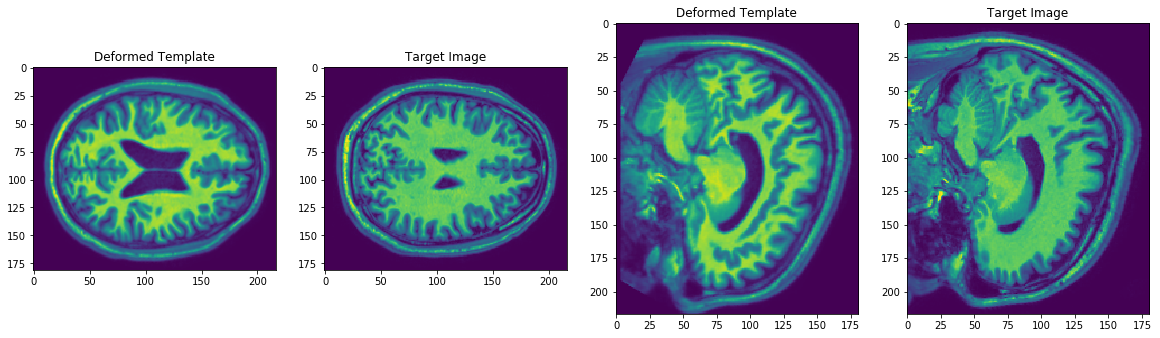

In [11]:
# display the deformed template according to the current transform
(deformed_template,_,_,_) = lddmm.applyThisTransform(template_image)
deformed_template = deformed_template[-1].cpu().numpy()
plt.figure()
plt.subplot(1,4,1)
plt.imshow(deformed_template[:,:,100])
plt.title('Deformed Template')
plt.subplot(1,4,2)
plt.imshow(target_image[:,:,100])
plt.title('Target Image')
plt.subplot(1,4,3)
plt.imshow(deformed_template[105,:,:])
plt.title('Deformed Template')
plt.subplot(1,4,4)
plt.imshow(target_image[105,:,:])
plt.title('Target Image')
plt.show()

In [ ]:
# output transforms
A = lddmm.outputTransforms() # output LDDMM and linear transforms
(phi0,phi1,phi2) = lddmm.computeThisDisplacement() # output resultant displacement field
deformed_template = lddmm.outputDeformedTemplate() # output deformed template as numpy array

# clear memory (the LDDMM object still exists and consumes some GPU memory but transforms are deleted)
lddmm.delete()